# Tutorial: Training a Voice Recognition Model¶

If you havent installed fastaudio do it uncommenting and executing the following cell

In [1]:
#!pip install git+https://github.com/fastaudio/fastaudio.git

In [1]:
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

from fastaudio.core.all import *
from fastaudio.augment.all import *

In [6]:
print(torch.ones(1))

tensor([1.])


In [4]:
speakers_folder = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)
speakers = speakers_folder.ls()
speakers[0]

Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00391.wav')

## Datablock and Basic End to End Training on 10 Speakers¶

In [5]:
#crop 2s from the signal and turn it to a MelSpectrogram with no augmentation
cfg_voice = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg_voice)

In [6]:
example = random.choice(speakers)
str(example).split('/')[-1][:5]

'f0001'

In [7]:
auds = DataBlock(blocks=(AudioBlock.from_folder(speakers_folder, crop_signal_to=2000), CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = a2s,
                 get_y=lambda x: str(x).split('/')[-1][:5]
                )

In [3]:
cats = [y for _,y in auds.datasets(speakers_folder)]

NameError: name 'auds' is not defined

In [10]:
#verify categories are being correctly assigned
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 9)

In [12]:
dbunch = auds.dataloaders(speakers_folder, bs=64)

<div class = "alert alert-block alert-info">Info:
Show batch is fixed now on nchannels, which is an object of AudioSpectrogram (part of sg settings but we overrode getattr to make it work like an attribute).</div>

/home/harry/miniconda3/envs/fastaudio/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/harry/miniconda3/envs/fastaudio/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


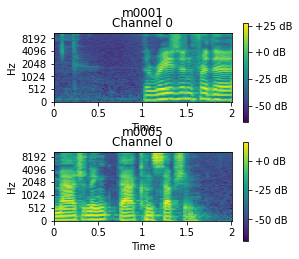

In [13]:
dbunch.show_batch(max_n=9)

In [14]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 251])

In [7]:
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [16]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.001737800776027143)

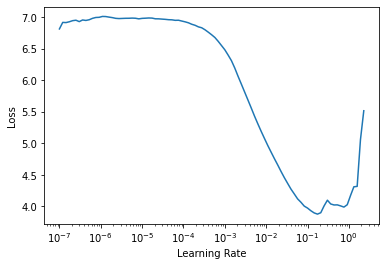

In [17]:
learn.lr_find()

In [18]:
#epochs are a bit longer due to the chosen melspectrogram settings
learn.fit_one_cycle(10, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.998272,2.375129,0.414062,00:07
1,0.849853,1.502091,0.575521,00:07
2,0.431611,1.446351,0.671875,00:07
3,0.226597,0.737888,0.845052,00:07
4,0.131332,0.985228,0.833333,00:07
5,0.078644,2.594059,0.574219,00:07
6,0.046894,0.229843,0.940104,00:07
7,0.025153,0.060095,0.986979,00:07
8,0.016655,0.034386,0.988281,00:07
9,0.011645,0.032150,0.992188,00:07
